# Compare CRE with CERES EBAF

This notebook makes maps and NMSE bar charts comparing CERES EBAF CRE with CAM4, CAM5, CAM6, and E3SM.

**NOTE**: the older version used ESMLab, which has been deprecated. Replacement functions are being added here (Sep 2022).

**NOTE**: This was copied from my `yellowstone` repo in Sep 2022; there may be another version floating around somewhere. The proper place for it is in the `cam456_cloud_eval` repo. 

**NOTE**: 22 February 2023 -- clean up and finalize for submission. Removing extraneous bits. Re-running to make sure everything is reproducible. Compare temporal sampling results for CAM6 and E3SM (starts: 1979, 2000; ends: 2010, 2014) and CERES (ends: 2010, 2014, 2020).

Using `computations.py` to keep things neat and portable.


_TODO_: Have to regularize the E3SM/EAM stuff... since it is in CMOR format etc etc


## regridding issues
The regridding tools available in python are limited, and even moreso when considering trying to work on Apple Silicon. I was able to GeoCAT compiled and working, but `linint2` is pretty limited. For example, it appears to be unable to "extrapolate" around longitudes when the destination grid has longitudes that are smaller than the minimum longitude in the source grid. 

Because of their reliance on `ESMF`, I can not currently use `ncremap`, `xESMF`, nor `ESMpy` on Apple Silicon. It might be possible to get NCO to work with other algorithms, but it would require some investigation.

I am able to install and use TempestRemap on my Mac. The process is a little cumbersome because EXODUS files need to be generated for each mesh (source and destination), and then a separate overlap file, and then the mapping file, and then there is another executable to apply the mapping. It does appear to work, but applying it to a large dataset with a lot of variables seemed slower than expected. 

**UPDATE**: I am able to run `ncremap -a nco` on Apple Silicon. I've done testing to compare with TempestRemap, and I believe TempestRemap is not always actually monotonic. The NCO algorithm appears to give good results, and I have switched to that for all my current remapping. 

## Adding E3SM to the mix
The E3SM data is on a 1° grid, which is convenient in some ways. I think it is the same grid as the CERES EBAF product, so no remapping would be needed for that case. The complication is that I want to be consistent between CAM and E3SM about what operations are performed. Maybe it is okay: I remap CERES to the CESM grid, and I would do the same for the E3SM grid, but they're the same. I guess I should just double check that the remapped averages are conserved. Ugh, but having to deal with mulitple grid is a pain... I could also just remap E3SM to the CAM grid; i.e., apply same mapping as CERES-to-CAM.

In [45]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmasher as cmr  # colormaps, access as cmap = plt.get_cmap('cmr.rainforest') 
from pathlib import Path
# import geocat.comp as gc ## --> should not be needed since all data is regridded

import computations as comp
import plotting_methods as plm

In [46]:
import socket

# Get the local host name

myHostName = socket.gethostname()

print("Name of the localhost is {}".format(myHostName))

Name of the localhost is cgdm-gravy


In [47]:
print(f"xarray version {xr.__version__}")
print(f"pandas version {pd.__version__}")

xarray version 2023.2.0
pandas version 1.5.3


In [48]:
def cheap_cyclic_interp(infield, outlike):
    # requires (lat, lon)
    # requires lon be evenly spaced
    dlon = infield['lon'][1]-infield['lon'][0]
    inshape = infield.shape
    tmp = np.zeros([inshape[0], inshape[1]+2])
    tmp[:,0] = infield[:,-1]
    tmp[:,1:-1] = infield
    tmp[:,-1] = infield[:,0]
    tmplon = np.zeros(inshape[1]+2)
    tmplon[0] = infield['lon'][0]-dlon
    tmplon[1:-1] = infield['lon']
    tmplon[-1] = infield['lon'][-1]+dlon
    tmp = xr.DataArray(tmp, dims=("lat","lon"), coords={"lat":infield["lat"], "lon":tmplon})
    print(tmp)
    return tmp.interp_like(outlike)

In [49]:
#
# Parameters 
#
# temporal sampling -- both CERES and CAM
# (1) begin_time = '2001-01-01' # None #
# (2)begin_time = '1979-01-01'
# (3)
begin_time = '2001-01-01'
#(1) finish_time = '2011-01-01' # None #
# (2) finish_time = '2014-12-31'
# (3) 
finish_time = '2021-12-31'


# Spatial averaging -- does it matter if we go -90-90 or -60-60?
# use the Regions dataclass:
latreg = plm.Regions('global', slice(-90,90), 'sixty') # use latreg.region_definition() to get string.



do_lon_flip = False

apply_remapping = False

## Temporal Sampling Results

### CERES Climo

* 2001-2011:
    - SW = -45.4
    - LW = 25.9
* 2001-2014:
    - SW = -45.4
    - LW = 25.9
* 2001-2021:
    - SW = -45.2
    - LW = 25.8

### Models 
* CAM4 200101 - 201012
    - SW = -48.21701892527246
    - LW = 25.699999835452758
* CAM5 200101 - 201012
    - SW = -49.14052557739068
    - LW = 22.19101735161553
* CAM6 200101 - 201012
    - SW = -47.55144597091241
    - LW = 23.735814198237733
* CAM6 197901 - 201012
    - SW = -47.43353258307563
    - LW = 23.88049814869929
* CAM6 197901 - 201412
    - SW = -47.442535432261394
    - LW = 23.851833952061654
* EAM 200101 - 201012
    - SW = -49.55228766164482
    - LW = 24.502804132617104
* EAM 197901 - 201012
    - SW = -49.43051556053896
    - LW = 24.58475917086232
* EAM 197901 - 201412
    - SW = -49.41708297110023
    - LW = 24.568208408360857
    
## Area Selection 
These are the values for averaging 60S to 60N.
* CAM4 200011 - 201012
    - SW = -51.778074656138436
    - LW = 27.292931436950408
* CAM5 200101 - 201012
    - SW = -53.44521740087679
    - LW = 23.74540809659867
* CAM6 197901 - 201412
    - SW = -50.29637647397031
    - LW = 25.069937573398324
* EAM 197901 - 201412
    - SW = -52.005979867464156
    - LW = 25.41786716192442
    


In [50]:
if myHostName in ['cgdm-gravy', 'cgdm-bespin']:
    disc = Path("/Volumes/Drudonna")
    if not disc.is_dir():
        raise IOError("The volume Drudonna is not a directory")
    data_loc = {'CAM4': disc/'cam4_1deg_release_amip/atm/proc/tseries/month_1',
               'CAM5': disc/'cam5_1deg_release_amip/atm/proc/tseries/month_1',
               'CAM6': disc/'f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1/atm/proc/tseries/month_1',
               'EAM': disc/'E3SM-1-0_amip'/'r1i1p1f1'/'remap'}
    # ceres = xr.open_dataset(disc/"CERES/CERES_EBAF_Ed4.1_Subset_200003-202102.nc", use_cftime=True)
    ceres = xr.open_mfdataset(sorted((disc/"CERES"/"monthly_files"/"remapped"/"fv09").glob("*.nc")), use_cftime=True)
else:
    data_loc = {
        'CAM4': Path('/glade/work/jonahshaw/archive/Kay_COSP_2012/cam4_1deg_release_amip/atm/proc/tseries/month_1'),
        'CAM5': Path('/glade/work/jonahshaw/archive/Kay_COSP_2012/cam5_1deg_release_amip/atm/proc/tseries/month_1'),
        'CAM6': Path('/glade/p/cesm/pcwg/jenkay/COSP/cesm21/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1/atm/proc/tseries/month_1')
    }
    ceres_loc = Path("/glade/work/brianpm/observations/ceres/")
    ceres_fils = ceres_loc.glob("CERES_EBAF_Ed4.1_Subset_*.nc")
    ceres = xr.open_mfdataset(sorted(list(ceres_fils)), combine='by_coords')

In [51]:
cam_swcf_fils = {}
cam_lwcf_fils = {}
for c in data_loc:
    cam_swcf_fils[c] = sorted(list(data_loc[c].glob("*.SWCF.*")))
    cam_lwcf_fils[c] = sorted(list(data_loc[c].glob("*.LWCF.*")))
cam_swcf = {c:(comp.open_cesm_dataset(cam_swcf_fils[c]))["SWCF"].load() for c in cam_swcf_fils}
cam_lwcf = {c:(comp.open_cesm_dataset(cam_lwcf_fils[c]))["LWCF"].load() for c in cam_swcf_fils}

# CLIMO 
# -- use time slice as defined above, just take time average
# --> comp.get_climo applies length-of-month weight
cam_swcf_climo = {c: comp.get_climo(cam_swcf[c].sel(time=slice(begin_time,finish_time))) for c in cam_swcf}
cam_lwcf_climo = {c: comp.get_climo(cam_lwcf[c].sel(time=slice(begin_time,finish_time))) for c in cam_lwcf}

if do_lon_flip: 
    # flip CAM longitude to -180-180:
    for c in cam_swcf_climo:
        cam_swcf_climo[c] = comp.lonFlip(cam_swcf_climo[c])
    for c in cam_lwcf_climo:
        cam_lwcf_climo[c] = comp.lonFlip(cam_lwcf_climo[c])

In [52]:

# CERES climo:
# slight error here b/c February assumed to have 28 days
ceres_swcf_climo = comp.get_climo(ceres['toa_cre_sw_mon'].sel(time=slice(begin_time,finish_time)))
ceres_lwcf_climo = comp.get_climo(ceres['toa_cre_lw_mon'].sel(time=slice(begin_time,finish_time)))

if do_lon_flip: 
    # Flip longitude (corrects the cyclic point issue -- needs to be -180 to 180)
    ceres_lwcf_climo = comp.lonFlip(ceres_lwcf_climo)
    ceres_swcf_climo = comp.lonFlip(ceres_swcf_climo)


In [53]:

if apply_remapping:
    # CERES - > remap to CAM grid
    # ceres_swcf_climo_remap = ceres_swcf_climo_cyc.interp_like(cam_swcf_climo['CAM4'])

    ceres_swcf_climo_remap = gc.linint2(ceres_swcf_climo, 
                                        cam_swcf_climo['CAM4']['lon'].values, 
                                        cam_swcf_climo['CAM4']['lat'].values,  
                                        xi=ceres_swcf_climo['lon'].values, 
                                        yi=ceres_swcf_climo['lat'].values, 
                                        icycx=True)

    ceres_lwcf_climo_remap = gc.linint2(ceres_lwcf_climo, 
                                        cam_lwcf_climo['CAM4']['lon'].values, 
                                        cam_lwcf_climo['CAM4']['lat'].values,  
                                        xi=ceres_lwcf_climo['lon'].values, 
                                        yi=ceres_lwcf_climo['lat'].values, 
                                        icycx=1)
else:
    ceres_swcf_climo_remap = ceres_swcf_climo
    ceres_lwcf_climo_remap = ceres_lwcf_climo


In [54]:
if hasattr(ceres_swcf_climo_remap, "compute"):
    ceres_swcf_climo_remap = ceres_swcf_climo_remap.compute()
if hasattr(ceres_lwcf_climo_remap, "compute"):
    ceres_lwcf_climo_remap = ceres_lwcf_climo_remap.compute()

Averaging region: 90S-90N


/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
 

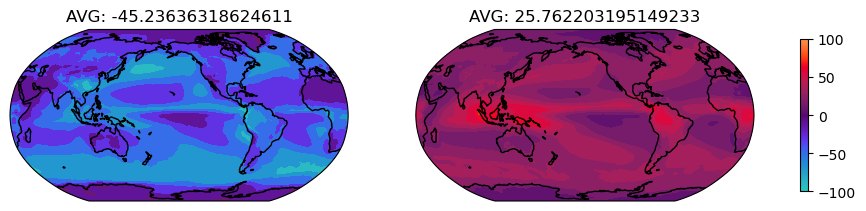

In [55]:
# Now show CERES climo for SW and LW
# include cyclic point
fig002, ax002 = plt.subplots(figsize=(12,6), ncols=2, subplot_kw={"projection":ccrs.Robinson(central_longitude=210)})
cnorm = mpl.colors.TwoSlopeNorm(vmin=-100, vcenter=0, vmax=100)

# Avoiding missing data in the plot : 
# - interpolate in longitude ... b/c CERES data starts at 0.5° but CAM starts at 0°
swplt = ceres_swcf_climo_remap.interpolate_na(dim='lon', method='linear').compute()
lwplt = ceres_lwcf_climo_remap.interpolate_na(dim='lon', method='linear').compute()

ceres_sw_cyc, cyclic_lons = add_cyclic_point(swplt, coord=swplt['lon'])
ceres_lw_cyc, cyclic_lons = add_cyclic_point(lwplt, coord=lwplt['lon'])

lons, lats = np.meshgrid(cyclic_lons, swplt['lat'].values)

img1 = ax002[0].contourf(lons, lats, ceres_sw_cyc, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('cmr.guppy_r'), norm=cnorm)

print(f"Averaging region: {latreg.region_definition()}")
area_average = ceres_swcf_climo_remap.sel(lat=latreg.latitudes).weighted(np.cos(np.radians(ceres_swcf_climo_remap.lat.sel(lat=latreg.latitudes)))).mean()
ax002[0].set_title(f"AVG: {area_average.item()}")

img2 = ax002[1].contourf(lons, lats, ceres_lw_cyc, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('cmr.guppy_r'), norm=cnorm)
area_average = ceres_lwcf_climo_remap.sel(lat=latreg.latitudes).weighted(np.cos(np.radians(ceres_lwcf_climo_remap.lat.sel(lat=latreg.latitudes)))).mean()
ax002[1].set_title(f"AVG: {area_average.item()}")

ax002[0].coastlines()
ax002[1].coastlines()
cb = fig002.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=plt.get_cmap('cmr.guppy_r')), ax=ax002, orientation='vertical', shrink=0.33)
# fig002.savefig("../Figures/ceres_ebaf_swcre_lwcre_climo.pdf", bbox_inches='tight')

In [56]:

def diff_dict(swcf, lwcf, obs_swcf, obs_lwcf):
    """
    Calculate difference in model vs obs climatologies.
    
    swcf : model SWCRE
    lwcf : model LWCRE
    obs_swcf : reference SWCRE
    obs_lwcf : reference LWCRE

    return a dict with keys:
    - dsw : difference between model and obs SWCRE
    - dlw : difference between model and obs LWCRE
    - bias_sw
    - bias_lw
    - rmse_sw
    - rmse_lw
    - nmse_u_lw
    - nmse_c_lw
    - nmse_p_lw
    - nmse_lw
    - nmse_u_sw
    - nmse_c_sw
    - nmse_p_sw
    - nmse_sw
    """
    out = {}
    obs_to_model_sw = obs_swcf # leftover from when we were trying to remap here
    obs_to_model_lw = obs_lwcf
    assert obs_to_model_sw.shape == swcf.shape
    assert obs_to_model_lw.shape == lwcf.shape
    # just make sure that the coordinates are exactly the same:
    print(f"Largest difference in latitude: {np.max(np.absolute(obs_to_model_sw['lat'].values - swcf['lat'].values))}")
    print(f"Largest difference in longitude: {np.max(np.absolute(obs_to_model_sw['lon'].values - swcf['lon'].values))}")
    for c in swcf.coords:
        if c in obs_to_model_sw.coords:
            obs_to_model_sw = obs_to_model_sw.assign_coords({c:swcf[c]})
    for c in lwcf.coords:
        if c in obs_to_model_lw.coords:
            obs_to_model_lw = obs_to_model_lw.assign_coords({c:lwcf[c]})

    wgt = np.cos(np.radians(swcf['lat']))
    out['dsw'] = swcf - obs_to_model_sw
    out['dlw'] = lwcf - obs_to_model_lw
    out['bias_sw'] = comp.global_average(out['dsw'], wgt).compute()
    out['bias_lw'] = comp.global_average(out['dlw'], wgt).compute()
    out['rmse_sw'] = comp.wgt_rmse(swcf, obs_to_model_sw, wgt)
    out['rmse_lw'] = comp.wgt_rmse(lwcf, obs_to_model_lw, wgt)
    u, c, p, svr = comp.nmse_components(lwcf, 
                              obs_to_model_lw, 
                              weights=None,
                              is_averaged=True)
    print(f"LW REPORT: {u = }, {c = }, {p = }, sum = {u+c+p}")
    out['nmse_u_lw'] = u
    out['nmse_c_lw'] = c
    out['nmse_p_lw'] = p
    out['nmse_lw'] = u+c+p
    u, c, p, svr = comp.nmse_components(swcf, 
                              obs_to_model_sw, 
                              weights=None, 
                              is_averaged=True)
    print(f"SW REPORT: {u = }, {c = }, {p = }, sum = {u+c+p}")
    out['nmse_u_sw'] = u
    out['nmse_c_sw'] = c
    out['nmse_p_sw'] = p
    out['nmse_sw'] = u+c+p
    return out



In [57]:
# plot pre-processing:

swplt = ceres_swcf_climo
lwplt = ceres_lwcf_climo
if hasattr(swplt,"compute"):
    swplt = swplt.compute()
if hasattr(lwplt, "compute"):
    lwplt = lwplt.compute()
    
print(f"[DEBUG] shapes: {swplt.shape}, {lwplt.shape}")

wgt = np.cos(np.radians(swplt['lat']))
ceres_sw_cyc, cyclic_lons = add_cyclic_point(swplt, coord=swplt['lon'])
ceres_lw_cyc, cyclic_lons = add_cyclic_point(lwplt, coord=lwplt['lon'])

print(f"[DEBUG] shapes of cyclic: {ceres_sw_cyc.shape}, {ceres_lw_cyc.shape}")

# Region selection built in here: 
cam4_diff = diff_dict(cam_swcf_climo['CAM4'].sel(lat=latreg.latitudes), cam_lwcf_climo['CAM4'].sel(lat=latreg.latitudes), ceres_swcf_climo.sel(lat=latreg.latitudes), ceres_lwcf_climo.sel(lat=latreg.latitudes))
cam5_diff = diff_dict(cam_swcf_climo['CAM5'].sel(lat=latreg.latitudes), cam_lwcf_climo['CAM5'].sel(lat=latreg.latitudes), ceres_swcf_climo.sel(lat=latreg.latitudes), ceres_lwcf_climo.sel(lat=latreg.latitudes))
cam6_diff = diff_dict(cam_swcf_climo['CAM6'].sel(lat=latreg.latitudes), cam_lwcf_climo['CAM6'].sel(lat=latreg.latitudes), ceres_swcf_climo.sel(lat=latreg.latitudes), ceres_lwcf_climo.sel(lat=latreg.latitudes))
e3sm_diff = diff_dict(cam_swcf_climo['EAM'].sel(lat=latreg.latitudes), cam_lwcf_climo['EAM'].sel(lat=latreg.latitudes), ceres_swcf_climo.sel(lat=latreg.latitudes), ceres_lwcf_climo.sel(lat=latreg.latitudes))

#
# plot parameters 
#
num_levels = 21
dlevels = np.linspace(-40, 40, num_levels) 

cnorm = mpl.colors.TwoSlopeNorm(vmin=-100, vcenter=0, vmax=100)
cnorm2 = mpl.colors.TwoSlopeNorm(vmin=-50, vcenter=0, vmax=50)

pad = 5 # in points


[DEBUG] shapes: (192, 288), (192, 288)
[DEBUG] shapes of cyclic: (192, 289), (192, 289)
Largest difference in latitude: 1.4210854715202004e-14
Largest difference in longitude: 0.0
LW REPORT: u = 3.2509665021015866e-05, c = 0.10528633004453106, p = 0.19962052111329776, sum = 0.30493936082284984
SW REPORT: u = 0.02209873932320242, c = 0.09333517859409117, p = 0.3686900787457297, sum = 0.48412399666302325
Largest difference in latitude: 1.4210854715202004e-14
Largest difference in longitude: 0.0
LW REPORT: u = 0.10715432695833872, c = 0.022448252248637463, p = 0.15427463356195936, sum = 0.2838772127689355
SW REPORT: u = 0.03791400027703818, c = 0.12498464807256864, p = 0.31612880085629047, sum = 0.4790274492058973
Largest difference in latitude: 0.0
Largest difference in longitude: 0.0
LW REPORT: u = 0.03561194450615148, c = 0.04528453301668062, p = 0.16628529496066358, sum = 0.24718177248349568
SW REPORT: u = 0.013210329656498298, c = 0.05612668614711727, p = 0.1767770632978486, sum = 0.

In [58]:
# # check on the global values
for c in cam_swcf_climo:
    tmp = cam_swcf_climo[c].sel(lat=latreg.latitudes)
    tmpw = np.cos(np.radians(tmp['lat']))
    print(f"{c} {tmp.date_bounds}\n SW = {tmp.weighted(tmpw).mean().item()}\n LW = {cam_lwcf_climo[c].sel(lat=latreg.latitudes).weighted(tmpw).mean().item()}")


CAM4 200101 - 201012
 SW = -48.21701892527246
 LW = 25.699999835452758
CAM5 200101 - 201012
 SW = -49.14052557739068
 LW = 22.19101735161553
CAM6 200101 - 201412
 SW = -47.54090661515097
 LW = 23.70344453558707
EAM 200101 - 201412
 SW = -49.48295468848633
 LW = 24.483660754254828


plotting row = 1
plotting row = 2
plotting row = 3
plotting row = 4
add annotations
Will try to save file: /Users/brianpm/Dropbox/Apps/Overleaf/cam_clouds_generations/Figures/cam456e3sm_ceres_cre_climo_timeselect_2001-01-01_2021-12-31_90S-90N.pdf


/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
 

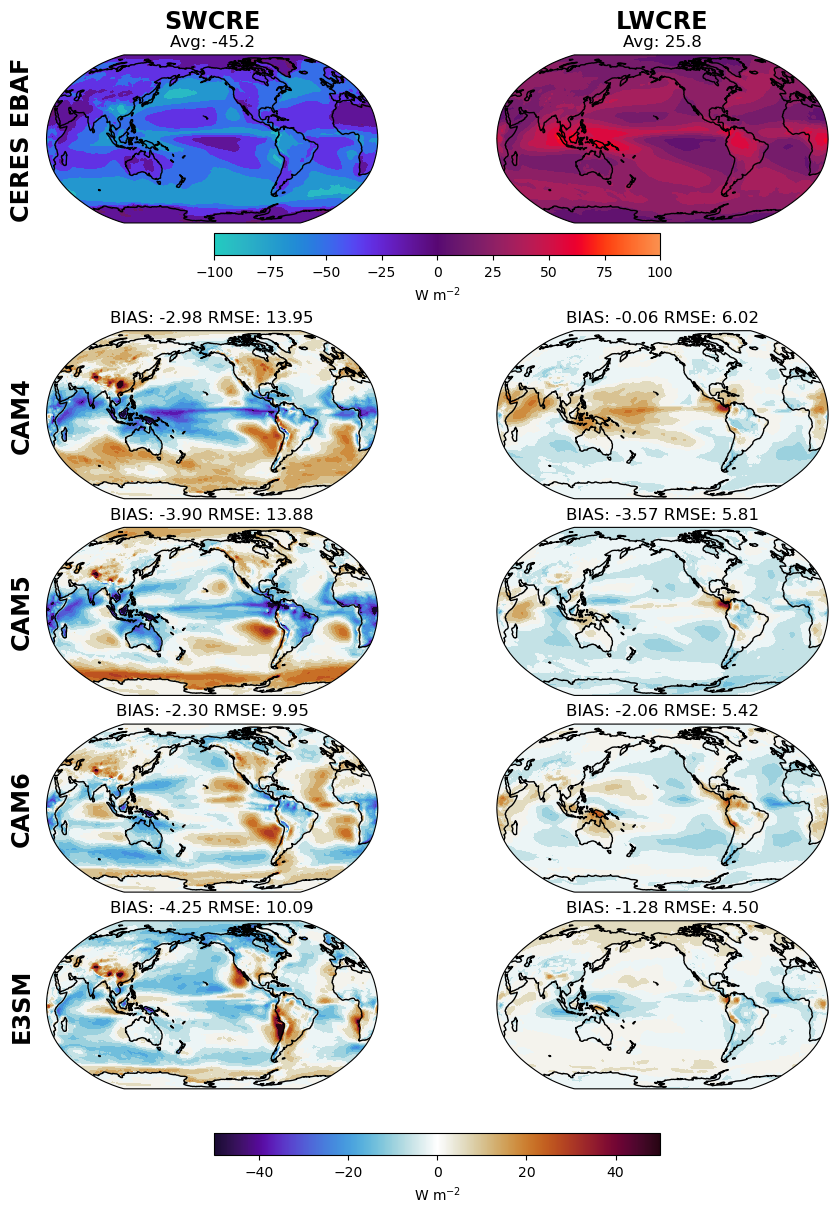

In [59]:
# Now show CERES climo for SW and LW
# And the difference for each model
fig003, ax003 = plt.subplots(
    figsize=(9, 12),
    ncols=2,
    nrows=5,
    subplot_kw={"projection": ccrs.Robinson(central_longitude=210)},
    constrained_layout=True,
)
# CERES CLIMO
lons, lats = np.meshgrid(cyclic_lons, ceres_swcf_climo_remap["lat"])
img1 = ax003[0, 0].contourf(
    lons,
    lats,
    ceres_sw_cyc,
    transform=ccrs.PlateCarree(),
    cmap=plt.get_cmap("cmr.guppy_r"),
    norm=cnorm,
)
img2 = ax003[0, 1].contourf(
    lons,
    lats,
    ceres_lw_cyc,
    transform=ccrs.PlateCarree(),
    cmap=plt.get_cmap("cmr.guppy_r"),
    norm=cnorm,
)
ax003[0, 0].coastlines()
ax003[0, 1].coastlines()
sw_r_title = ax003[0, 0].set_title(
    f"Avg: {comp.global_average(swplt, wgt).item():4.1f}", loc="center"
)
lw_r_title = ax003[0, 1].set_title(
    f"Avg: {comp.global_average(lwplt, wgt).item():4.1f}", loc="center"
)

cb_ceres = fig003.colorbar(
    mpl.cm.ScalarMappable(norm=cnorm, cmap=plt.get_cmap("cmr.guppy_r")),
    ax=ax003[0, :],
    orientation="horizontal",
    shrink=0.5,
)
cb_ceres.set_label("W m$^{-2}$")

for row, model in enumerate([cam4_diff, cam5_diff, cam6_diff, e3sm_diff], start=1):
    print(f"plotting {row = }")
    try:
        model_sw_cyc, model_lon_cyc = add_cyclic_point(
            model["dsw"], coord=model["dsw"]["lon"]
        )
    except:
        print("PROBLEM")
        print(model["dsw"]["lon"])
    model_lw_cyc, model_lon_cyc = add_cyclic_point(
        model["dlw"], coord=model["dlw"]["lon"]
    )
    lons, lats = np.meshgrid(model_lon_cyc, model["dsw"]["lat"])
    ax003[row, 0].contourf(
        lons,
        lats,
        model_sw_cyc,
        levels=dlevels,
        extend="both",
        transform=ccrs.PlateCarree(),
        cmap=plt.get_cmap("cmr.fusion_r"),
        norm=cnorm2,
    )
    ax003[row, 1].contourf(
        lons,
        lats,
        model_lw_cyc,
        levels=dlevels,
        extend="both",
        transform=ccrs.PlateCarree(),
        cmap=plt.get_cmap("cmr.fusion_r"),
        norm=cnorm2,
    )
    ax003[row, 0].coastlines()
    ax003[row, 1].coastlines()
    ax003[row, 0].set_title(
        f"BIAS: {model['bias_sw']:4.2f} RMSE: {model['rmse_sw']:4.2f}"
    )
    ax003[row, 1].set_title(
        f"BIAS: {model['bias_lw']:4.2f} RMSE: {model['rmse_lw']:4.2f}"
    )

# Colorbar
cb_diff = fig003.colorbar(
    mpl.cm.ScalarMappable(norm=cnorm2, cmap=plt.get_cmap("cmr.fusion_r")),
    ax=ax003[1:, :],
    orientation="horizontal",
    shrink=0.5,
)
cb_diff.set_label("W m$^{-2}$")


# Annotation
print("add annotations")
ax003[0, 0].annotate(
    "SWCRE",
    xy=(0.5, 1.2),
    xycoords="axes fraction",
    rotation=0,
    size="xx-large",
    weight="semibold",
    ha="center",
    va="center",
    textcoords="offset points",
    xytext=(0, 0),
)

ax003[0, 1].annotate(
    "LWCRE",
    xy=(0.5, 1.2),
    xycoords="axes fraction",
    rotation=0,
    size="xx-large",
    weight="semibold",
    ha="center",
    va="center",
    textcoords="offset points",
    xytext=(0, 0),
)

ax003[0, 0].annotate(
    "CERES EBAF",
    xy=(0, 0.5),
    xycoords="axes fraction",
    rotation=90,
    size="xx-large",
    weight="semibold",
    ha="right",
    va="center",
    textcoords="offset points",
    xytext=(-ax003[1, 0].yaxis.labelpad - pad, 0),
)
ax003[1, 0].annotate(
    "CAM4",
    xy=(0, 0.5),
    xycoords="axes fraction",
    rotation=90,
    size="xx-large",
    weight="semibold",
    ha="right",
    va="center",
    textcoords="offset points",
    xytext=(-ax003[1, 0].yaxis.labelpad - pad, 0),
)
ax003[2, 0].annotate(
    "CAM5",
    xy=(0, 0.5),
    xycoords="axes fraction",
    rotation=90,
    size="xx-large",
    weight="semibold",
    ha="right",
    va="center",
    textcoords="offset points",
    xytext=(-ax003[1, 0].yaxis.labelpad - pad, 0),
)
ax003[3, 0].annotate(
    "CAM6",
    xy=(0, 0.5),
    xycoords="axes fraction",
    rotation=90,
    size="xx-large",
    weight="semibold",
    ha="right",
    va="center",
    textcoords="offset points",
    xytext=(-ax003[1, 0].yaxis.labelpad - pad, 0),
)
ax003[4, 0].annotate(
    "E3SM",
    xy=(0, 0.5),
    xycoords="axes fraction",
    rotation=90,
    size="xx-large",
    weight="semibold",
    ha="right",
    va="center",
    textcoords="offset points",
    xytext=(-ax003[1, 0].yaxis.labelpad - pad, 0),
)

ofil = f"/Users/brianpm/Dropbox/Apps/Overleaf/cam_clouds_generations/Figures/cam456e3sm_ceres_cre_climo_timeselect_{begin_time}_{finish_time}_{latreg.region_definition()}.pdf"
print(f"Will try to save file: {ofil}")
fig003.savefig(ofil, bbox_inches="tight")

components sum: 0.48412399666302325, nmse_sw: 0.48412399666302325
components sum: 0.4790274492058973, nmse_sw: 0.4790274492058973
components sum: 0.24611407910146416, nmse_sw: 0.24611407910146416
components sum: 0.253471906018566, nmse_sw: 0.253471906018566


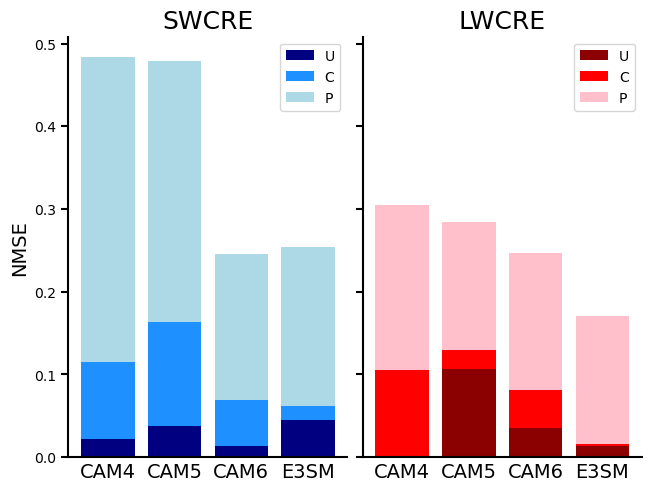

In [60]:
# for context, we can look at the NMSE

fig004, ax004 = plt.subplots(ncols=2, sharey=True, constrained_layout=True)
ubias = []
cbias = []
perr = []
for i in [cam4_diff, cam5_diff, cam6_diff, e3sm_diff]:
    ubias.append(i['nmse_u_sw'])
    cbias.append(i['nmse_c_sw'])
    perr.append(i['nmse_p_sw'])
    print(f"components sum: {(ubias[-1]+cbias[-1]+perr[-1])}, nmse_sw: {i['nmse_sw']}")
ax004[0].bar(np.arange(len(ubias)), ubias, label="U", color='navy')
ax004[0].bar(np.arange(len(cbias)), cbias, bottom=ubias, label="C", color='dodgerblue')
ax004[0].bar(np.arange(len(perr)), perr, bottom=np.array(cbias)+np.array(ubias), label="P", color='lightblue')
ax004[0].set_title("SWCRE", fontsize=18)
ubias = []
cbias = []
perr = []
for i in [cam4_diff, cam5_diff, cam6_diff, e3sm_diff]:
    ubias.append(i['nmse_u_lw'])
    cbias.append(i['nmse_c_lw'])
    perr.append(i['nmse_p_lw'])
ax004[1].bar(np.arange(len(ubias)), ubias, label="U", color='darkred')
ax004[1].bar(np.arange(len(cbias)), cbias, bottom=ubias, label="C", color='red')
ax004[1].bar(np.arange(len(perr)), perr, bottom=np.array(cbias)+np.array(ubias), label="P", color='pink')
ax004[1].set_title("LWCRE", fontsize=18)
ax004[0].set_xticks([0, 1, 2, 3])
ax004[0].set_xticklabels(["CAM4", "CAM5", "CAM6", "E3SM"], fontsize=14)
ax004[1].set_xticks([0, 1, 2, 3])
ax004[1].set_xticklabels(["CAM4", "CAM5", "CAM6", "E3SM"], fontsize=14)
ax004[0].legend()
ax004[1].legend()
[a.spines['top'].set_visible(False) for a in ax004]
[a.spines['right'].set_visible(False) for a in ax004]

ax004[0].set_ylabel("NMSE", fontsize=14)
# plt.setp(ax004.get_yticklabels(), Fontsize=14)

for a in ax004:
    for s in a.spines:
        a.spines[s].set_linewidth(1.5)
    a.tick_params(axis='y', width=1.5, length=5)
    a.tick_params(axis='x', width=1.5, length=0)



fig004.savefig(f"/Users/brianpm/Dropbox/Apps/Overleaf/cam_clouds_generations/Figures/cam456e3sm_ceres_nmse_climo_timeselect_{begin_time}_{finish_time}_{latreg.region_definition()}.pdf", bbox_inches='tight')